# 时序预测

## 环境设置

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams["figure.figsize"] = (8,6)
mpl.rcParams["axes.grid"] = False

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

## 天气数据集

In [3]:
zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)

教程基于小时进行预测，因此需要将数据从十分钟级转换成小时级

In [4]:
# 仅处理每小时的预测
# 从10分钟间隔到1h对数据进行二次采样
df = pd.read_csv(csv_path)
df = df[5::6]
date_time = pd.to_datetime(df.pop("Date Time"), format="%d.%m.%Y %H:%M:%S")

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


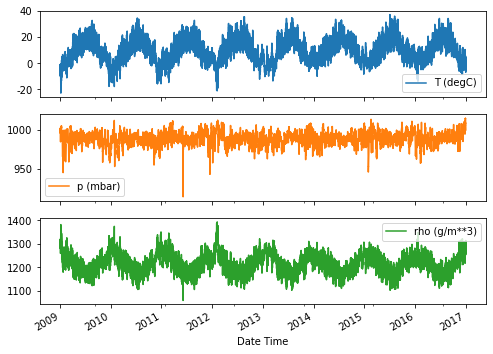

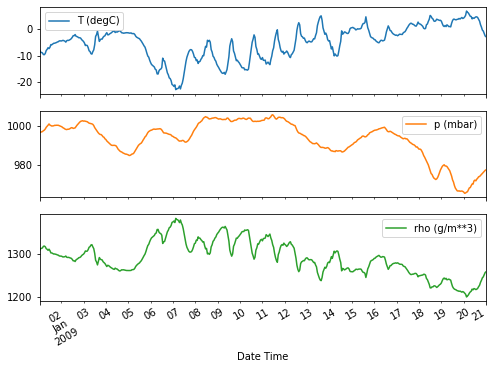

In [6]:
plot_cols = ["T (degC)", "p (mbar)", "rho (g/m**3)"]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### 检查与清理

In [7]:
# 检测和清理
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [8]:
# 风速列：mv和max. mv列的-9999可能是错误的
wv = df["wv (m/s)"]
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df["max. wv (m/s)"]
bad_max_wv = max_wv == -9999.0
max_wv["bad_max_wv"] = 0.0

df["wv (m/s)"].min()

0.0

### 特征工程


Text(0, 0.5, '风速 [m/s]')

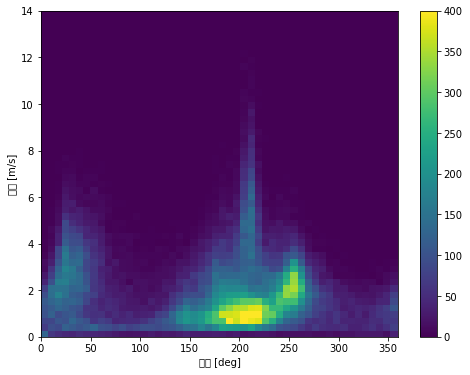

In [9]:
# 风向
plt.hist2d(df["wd (deg)"], df["wv (m/s)"], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel(u"风向 [deg]")
plt.ylabel(u"风速 [m/s]")

In [10]:
# 获得风向量
wv = df.pop("wv (m/s)")     # pop方法弹出一列
max_wv = df.pop("max. wv (m/s)")

# 转换成弧度
wd_rad = df.pop("wd (deg)") * np.pi / 180

# 计算风的x和y成分
df["Wx"] = wv * np.cos(wd_rad)
df["Wy"] = wv * np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

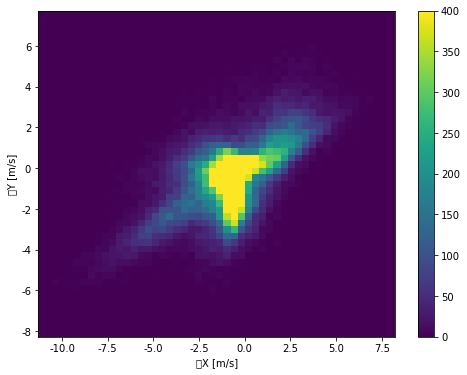

In [11]:
# 风向量更适合建模可解释
plt.hist2d(df["Wx"], df["Wy"], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel(u"风X [m/s]")
plt.ylabel(u"风Y [m/s]")
ax = plt.gca()
ax.axis("tight")

上几步将原本的风速、风向特征转换用风向量来表示

### 时间
将时间转换成秒的形式

In [12]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [13]:
# 使用sin和cos将时间转换成“每天的时间”和“年的时间”
day = 24 * 60 * 60
year = (365.2425) * day

df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


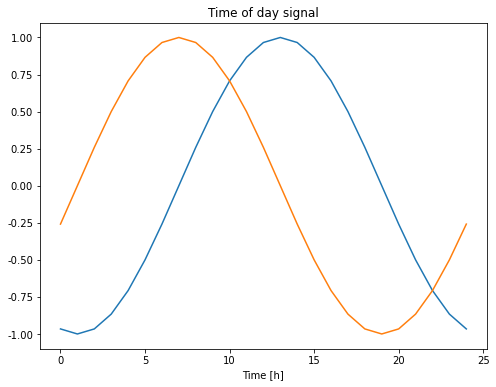

In [14]:
plt.plot(np.array(df["Day sin"])[:25])
plt.plot(np.array(df["Day cos"])[:25])
plt.xlabel("Time [h]")
plt.title("Time of day signal")

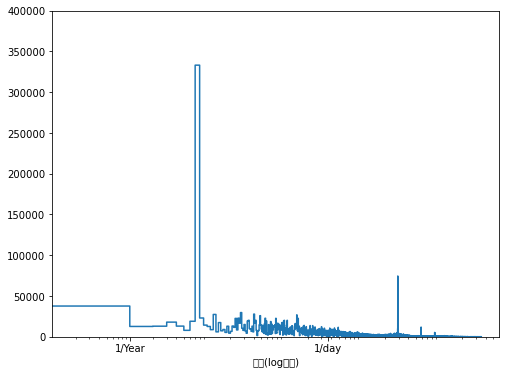

In [15]:
# 使得模型能够访问最重要的频率特征。能够知晓哪些频率是重要的
fft = tf.signal.rfft(df["T (degC)"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["T (degC)"])
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / (hours_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_dataset, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
_ = plt.xlabel(u"频率(log尺度)")

### 划分数据
使用`(70%, 20%, 10%)`划分训练集、验证集和测试集。数据在划分前没有进行打乱，原因如下：  
1. 确保输入窗口的分割数据是连续样本的  
2. 确保验证/测试结果更真实，评估数据在模型训练之后

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### 数据归一化
训练神经网络前，放缩特征是非常重要的。标准化是常用方法。  
均值与标准差只能通过 __训练集__ 计算，使得模型无法获得验证集和测试集的数据。  
理论上，标准化应当使用变化的均值，但是简单起见，还是使用简答的均值。

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

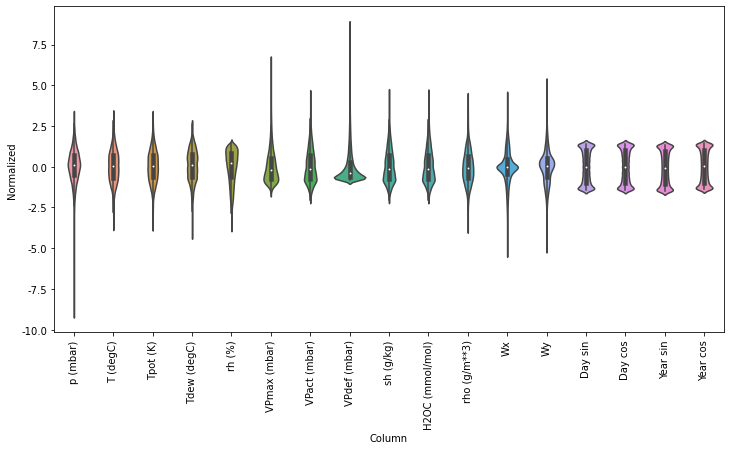

In [18]:
# 查看特征的分布。一些特征有长尾，但是没有类似-9999这种明显的错误
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## 数据窗口
输入窗口的主要特性有：  
* 输入与标签窗口的宽度（时间步长）
* 之间的时间偏移
* 哪些特征使用在了输入、标签或者二者都

教程建立了不同的模型，为它们使用：  
* 单输出和多输出预测
* 单时间步长预测和多时间不长预测

### 1.索引与偏移

创建`WindowGenerator`类。构造函数包含输入与标签索引的必要逻辑。

In [19]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None):
        # 存储原数据
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # 获得标签列索引
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # 获得窗口参数
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join([
            f"Total window size: {self.total_window_size}",
            f"Input indices: {self.input_indices}",
            f"Label indices: {self.label_indices}",
            f"Label column name(s): {self.label_columns}"
        ])

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=["T (degC)"])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=["T (degC)"])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 分割

给定列表的连续输入，`split_window`方法会将它们转化成一个输入窗口和标签窗口。

In [22]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # 分片并不会保留静态形状信息，手动设置形状
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [23]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
    np.array(train_df[100:100+w2.total_window_size]),
    np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print("All shape are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"labels shape: {example_labels.shape}")

All shape are: (batch, time, features)
Window shape: (3, 7, 17)
Inputs shape: (3, 6, 17)
labels shape: (3, 1, 1)


### 绘图

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col="T (degC)", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label="Inputs", marker=".", zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors="k", label="Labels", c="#2ca02c", s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker="X", edgecolors="k", label="Predictions", c="#ff7f0e", s=64)

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")

WindowGenerator.plot = plot


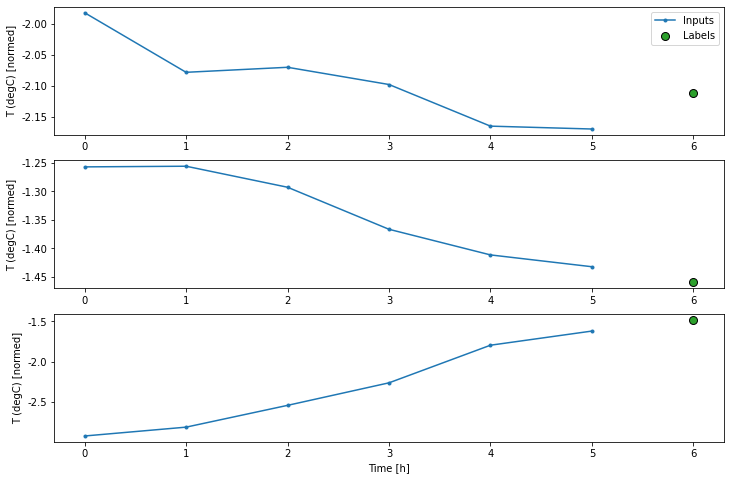

In [26]:
w2.plot()

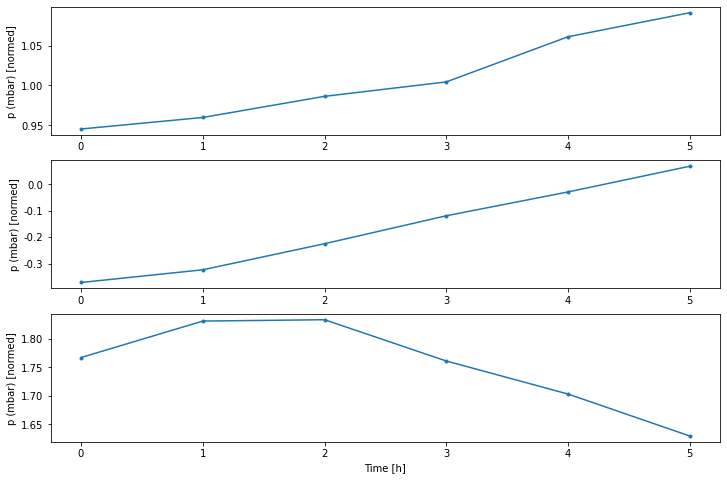

In [27]:
w2.plot(plot_col="p (mbar)")

### 4.创建`tf.data.Datasets`

`make_dataset`方法会将时序DataFrame转换成`(input_window, label_window)`对形式的`tf.data.Dataset`

In [28]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [29]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    result = getattr(self, "_example", None)
    if result is None:
        result = next(iter(self.train))
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [30]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 17), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [31]:
for example_inputs, example_labels in w2.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 6, 17)
Labels shape (batch, time, features): (32, 1, 1)


## 单步模型

In [34]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=["T (degC)"])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [35]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 1, 17)
Labels shape (batch, time, features): (32, 1, 1)


### 基准

将温度的预测结果为“无变化”设置为基线

In [36]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [37]:
baseline = Baseline(label_index=column_indices["T (degC)"])
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [38]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=["T (degC)"])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [39]:
print("Input shape:", single_step_window.example[0].shape)
print("Output shape:", baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 17)
Output shape: (32, 1, 1)


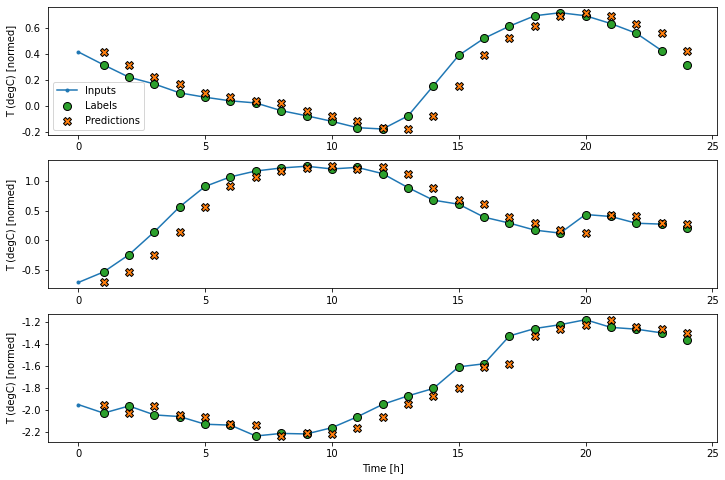

In [40]:
wide_window.plot(baseline)

### 线性模型

In [41]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [42]:
print("Input shape:", single_step_window.example[0].shape)
print("Output shape:", linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 17)
Output shape: (32, 1, 1)


In [43]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, mode="min")

    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])
    return history

In [44]:
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val)
performance["Linear"] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.2440 - mean_absolute_error: 0.2881 - val_loss: 0.0125 - val_mean_absolute_error: 0.0837
Epoch 2/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0101 - mean_absolute_error: 0.0737 - val_loss: 0.0087 - val_mean_absolute_error: 0.0680
Epoch 3/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0693 - val_loss: 0.0087 - val_mean_absolute_error: 0.0680
Epoch 4/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0694 - val_loss: 0.0086 - val_mean_absolute_error: 0.0675
Epoch 5/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0695 - val_loss: 0.0086 - val_mean_absolute_error: 0.0678
Epoch 6/20
439/439 [==============================] - 0s 863us/step - loss: 0.0086 - mean_absolute_error: 0.0680


In [45]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 17)
Output shape: (32, 24, 1)


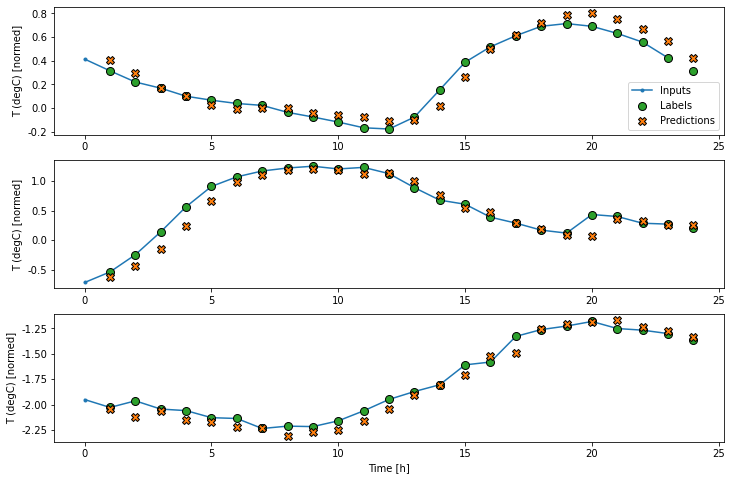

In [46]:
wide_window.plot(linear)

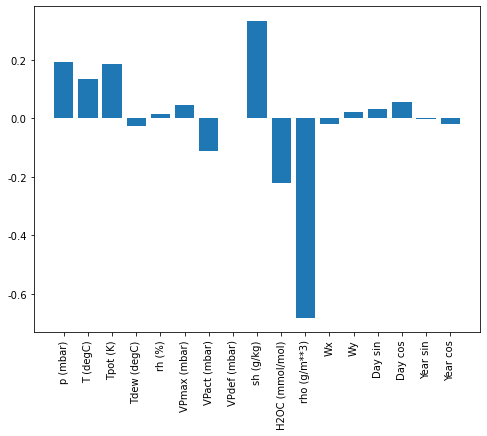

In [47]:
# 查看权重赋值情况
plt.bar(x=range(len(train_df.columns)), height=linear.layers[0].kernel[:, 0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### 全连接